# Helmholtz 1D: Ideal TV & Coarsening for Estimating Relaxation Smoothing

## Goal
Coarrsen 1D Helhmholtz operator $A = \Delta + k^2 I$ on a fixed domain with constant k using repetitive coarsening.

## Discretization
We use the 5-point finite difference $A^h = [-1, 16, -30 + 12 (kh)^2, 16, -1]$. 

In this experiment we use a fixed periodic domain with $n=96$ points and a small various $kh$ values. We use the idealized test functions = lowest eigenvectors of $A^h$.

In [1]:
import collections
import logging
import numpy as np
import matplotlib.pyplot as plt
import helmholtz as hm
import pandas as pd
import scipy.sparse
import sklearn.metrics.pairwise
import sys
from numpy.ma.testutils import assert_array_almost_equal
from scipy.linalg import eig, norm, svd
from scipy.sparse.linalg import eigs

%load_ext autoreload
%autoreload 2

np.set_printoptions(linewidth=500, precision=2, suppress=True, threshold=100000)
for handler in logging.root.handlers[:]: logging.root.removeHandler(handler)
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(levelname)-8s %(message)s",
                    datefmt="%a, %d %b %Y %H:%M:%S")

logger = logging.getLogger("main")

## Level 0->1 Coarsening
* For various $kh$ values:
* Idealized TV = 2 lowest Eigenvectors.
* Using 10 samples (windows) from each vector.

In [2]:
# Fixed seed for reproducible results.
np.random.seed(0)

n = 96
num_examples = 2
num_windows = 10
threshold = 0.1

kh_values = np.array([0, 0.25, 0.5, 0.7, 1, 2**0.5, 2])
# Exactly 12 gridpoints per wavelength.
#kh = 0.52338538
# Aggregate size must evenly divide the domain size.
aggregate_size_values = np.array([2, 4, 6, 8], dtype=int)
# Mock cycle #relaxations per cycle.
nu_values = np.arange(1, 12, dtype=int)

In [3]:
def ideal_tv(a, num_examples):
    """Returns a test matrix of the 'num_examples' lowest eigenvectors of a and an array of the
    corresponding eigenvalues.
    
    Note: scipy may return complex eigenvectors, but a symmetric matrix always has orthogonal real
    eigenvectors. See https://math.stackexchange.com/questions/47764/can-a-real-symmetric-matrix-have-complex-eigenvectors
    for explanation. 𝐴(𝑎+𝑖𝑏)=𝜆(𝑎+𝑖𝑏)⇒𝐴𝑎=𝜆𝑎  and 𝐴𝑏=𝜆𝑏. Thus we return the real part of v here."""
    lam, v = eig(a.todense())
    lam = np.real(lam)
    v = np.real(v)
    ind = np.argsort(np.abs(lam))
    lam = lam[ind]
    v = v[:, ind]
    return v[:, :num_examples], lam


def create_coarsening(a, x, num_windows, aggregate_size):
    """Returns a coarsening of a repetitive Helmholtz problem a from windows of the test matrix x."""
    return hm.setup.coarsening.create_coarsening(
        np.concatenate(tuple(hm.linalg.get_window(x, offset, aggregate_size) 
                                     for offset in range(num_windows)), axis=1).transpose(), 
                threshold)


def mock_cycle_conv_factor(level, x, aggregate_size_values, nu_values):
    """Returns a matrix of mock cycle convergence factors (agg size x nu)."""
    return np.array([
        np.array([hm.setup.auto_setup.mock_cycle_conv_factor(
            level, 
            create_coarsening(a, x, num_windows, aggregate_size)[0].tile(level.a.shape[0] // aggregate_size),
            nu) for nu in nu_values])
            for aggregate_size in aggregate_size_values
    ])

def plot_coarsening_result(result):
    kh_values = result.keys()
    fig, axs = plt.subplots(len(kh_values), 5, figsize=(16, 3 * len(kh_values)))
    for row, kh in enumerate(kh_values):
        info = result[kh]
        x, lam, level, mock_conv, nc, aggregate_size, r, s = \
            info["x"], info["lam"], info["level"], info["mock_conv"], info["nc"], info["aggregate_size"], \
            info["r"], info["s"]

        ax = axs[row, 0]
        ax.plot(lam[:20], "rx")
        ax.grid(True)
        ax.set_xlabel("i")
        ax.set_title(r"Eigenvalues $\lambda_i$");
        ax.set_ylabel("kh {:.2f}".format(kh))

        ax = axs[row, 1]
        # R should be real-valued, but cast just in case.
        ax.set_title("Test Functions")
        for i, xi in enumerate(x.transpose()):
            ax.plot(xi, label=r"$\lambda = {:.2e}$".format(lam[i]))
        ax.grid(True);

        # R should be real-valued, but cast just in case.
        ax = axs[row, 2]
        for i, ri in enumerate(np.real(r.asarray())):
            ax.plot(ri)
        ax.set_title("R rows, |Agg| {}".format(aggregate_size))
        ax.grid(True);

        ax = axs[row, 3]
        ax.plot(aggregate_size_values, nc / aggregate_size_values, 'o-')
        ax.grid(True);
        ax.set_title("Coarsening Rat. nc {}".format(np.array2string(nc)));
        ax.set_ylabel("CR")
        ax.set_xlabel("Aggregate Size")

        ax = axs[row, 4]
        for aggregate_size, conv in zip(aggregate_size_values, mock_conv):
            ax.plot(nu_values, conv, label="Agg {}".format(aggregate_size))
        ax.legend(loc="upper right");
        ax.set_ylim([0, 1])
        ax.grid(True);
        ax.set_ylabel("Conv Factor")
        ax.set_xlabel(r"$\nu$")
        ax.set_title("Mock Cycle Conv Factor");

In [4]:
result = collections.OrderedDict()
for kh in kh_values:
    a = hm.linalg.helmholtz_1d_5_point_operator(kh, n).tocsr()
    x, lam = ideal_tv(a, num_examples)
    level = hm.setup.hierarchy.create_finest_level(a)
    mock_conv = mock_cycle_conv_factor(level, x, aggregate_size_values, nu_values)
    nc = np.array([create_coarsening(a, x, num_windows, aggregate_size)[0].asarray().shape[0] 
                   for aggregate_size in aggregate_size_values])
    aggregate_size = 4
    r, s = create_coarsening(a, x, num_windows, aggregate_size)
    r_csr = r.tile(level.a.shape[0] // aggregate_size)
    p_csr = r_csr.transpose()
    coarse_level = hm.setup.hierarchy.create_coarse_level(level.a, level.b, r_csr, p_csr)
    result[kh] = {"x": x, "lam": lam, "level": level, "mock_conv": mock_conv, "nc": nc, 
                  "aggregate_size": aggregate_size, "r": r, "s": s,
                 "coarse_level": coarse_level}

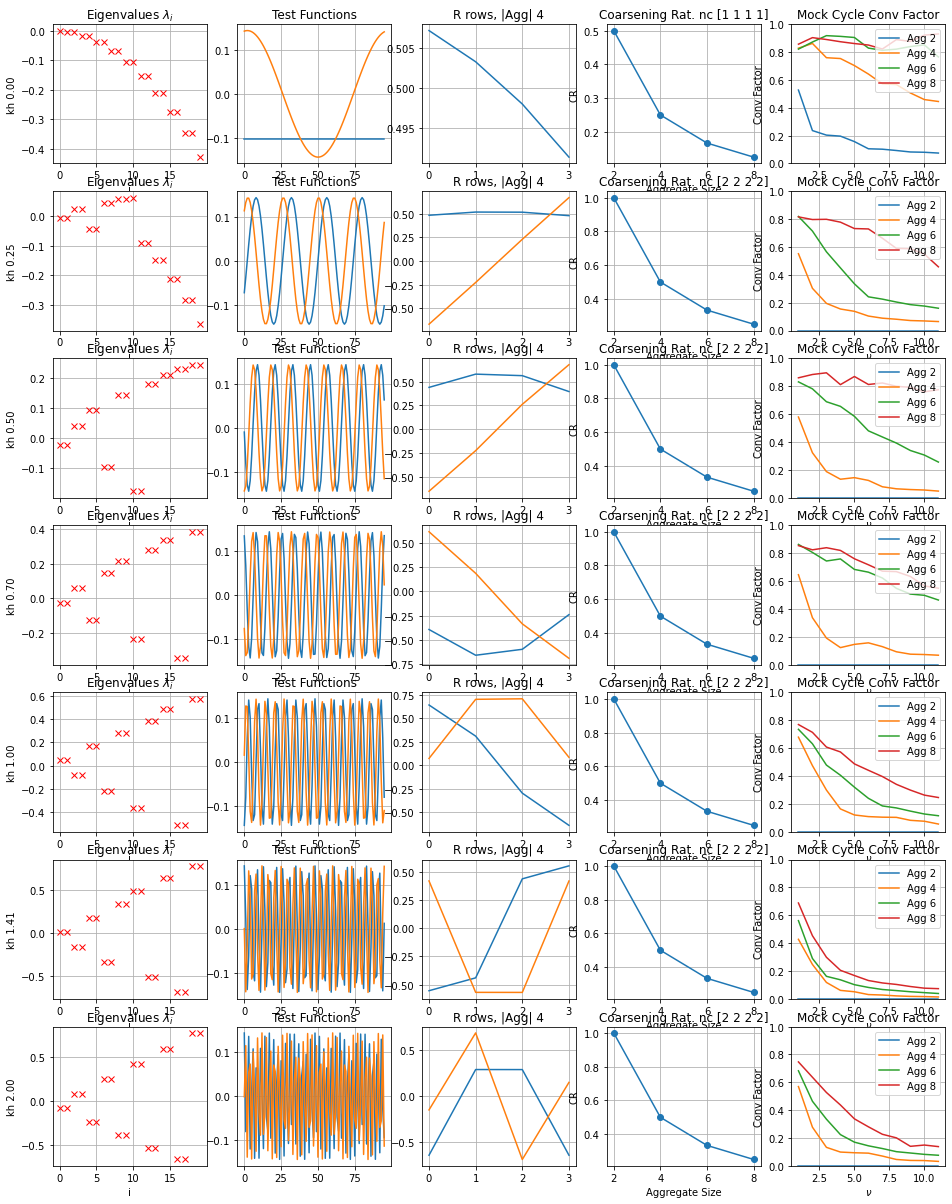

In [5]:
plot_coarsening_result(result)

Looks like the transitional value $kh = 0.5$ poses the largest difficulty (Kaczmarz smoothing is least efficient there), although for aggregate size = 4 (only!) we get a good result there too.

### Example of Intepreting the Coarse Equations for $kh = 0.5$
Interpret the equation via rotation = diagonalization of central block.

In [6]:
kh = 0.5
aggregate_size = 4
caliber = 2

a = hm.linalg.helmholtz_1d_5_point_operator(kh, n).tocsr()
level = hm.setup.hierarchy.create_finest_level(a)
x, lam = ideal_tv(a, num_examples)
print(x.shape)

r, s = create_coarsening(a, x, num_windows, aggregate_size)
num_aggregates = a.shape[0] // aggregate_size
r_csr = r.tile(num_aggregates)
#p_csr = r_csr.transpose()

num_windows = 10
x_disjoint_aggregate_t = np.concatenate(tuple(hm.linalg.get_window(x, aggregate_size * offset, aggregate_size)
                                              for offset in range(num_windows)), axis=1).transpose()
xc = r_csr.dot(x)
num_coarse_vars = xc.shape[0]
print(xc.shape)
xc_disjoint_aggregate_t = np.concatenate(tuple(hm.linalg.get_window(xc, offset, num_coarse_vars)
                                               for offset in range(num_windows)), axis=1).transpose()
p_csr = r_csr.transpose()
# p = hm.setup.interpolation.create_interpolation("svd",
#                                                 r.asarray(), x_disjoint_aggregate_t, xc_disjoint_aggregate_t,
#                                           a.shape[0], nc, caliber)

multilevel = hm.hierarchy.multilevel.Multilevel(level)
coarse_level = hm.setup.hierarchy.create_coarse_level(level.a, level.b, r_csr, p_csr)
multilevel.level.append(coarse_level)

(96, 2)
(48, 2)


In [7]:
print("Fine-level stencil")
print(np.array(level.a.todense()[4:6, 2:8]))
print("SVD Coarsening")
print(s)
print(r.asarray())

ac = coarse_level.a
#print(ac[0].nonzero(), ac[0].data)
print("Coarse-level stencil")
b = np.array(ac[4:6, 2:8].todense())
print(b)
rot = eig(b[:, 2:4])[1]
print("Central block rotation")
print(rot)
print("Is it a rotation? {}".format(norm(rot.dot(rot.transpose()) - np.eye(rot.shape[0])) < 1e-12))
b0, b1, b2 = (rot.transpose().dot(b[:, :2])).dot(rot), (rot.transpose().dot(b[:, 2:4])).dot(rot), (rot.transpose().dot(b[:, 4:6])).dot(rot)
print("After diagonalizing the central block")
print(np.concatenate((b0, b1, b2), axis=1))

print("Diagonalization of neighboring block")
l, v = eig(b0)
print("eigenvalues", l)
print("eigenvectors")
print(v)
print("Is it a rotation? {}".format(norm(v.dot(v.transpose()) - np.eye(v.shape[0])) < 1e-12))

Fine-level stencil
[[-0.08  1.33 -2.25  1.33 -0.08  0.  ]
 [ 0.   -0.08  1.33 -2.25  1.33 -0.08]]
SVD Coarsening
[0.77 0.49 0.   0.  ]
[[ 0.44  0.58  0.56  0.4 ]
 [-0.65 -0.22  0.26  0.68]]
Coarse-level stencil
[[ 0.19  0.35 -0.19  0.04  0.19 -0.31]
 [-0.31 -0.56  0.04 -1.49  0.35 -0.56]]
Central block rotation
[[ 1.   -0.03]
 [ 0.03  1.  ]]
Is it a rotation? True
After diagonalizing the central block
[[ 0.19  0.33 -0.19  0.    0.19 -0.33]
 [-0.33 -0.56  0.   -1.49  0.33 -0.56]]
Diagonalization of neighboring block
eigenvalues [-0.  +0.j -0.37+0.j]
eigenvectors
[[ 0.86 -0.51]
 [-0.51  0.86]]
Is it a rotation? False


In [8]:
two_level_cycle = lambda x: hm.solve.solve_cycle.solve_cycle(multilevel, 1.0, 0, 6).run(x)
y, conv_factor = hm.solve.run.run_iterative_method(level.operator, two_level_cycle,
                                                np.random.random((a.shape[0], )), 20,
                                                print_frequency=1)
y = y.flatten()
print("Conv Factor {:.5f}".format(conv_factor))

INFO         0 |r| 9.71802408e+00 RER 1.60916
INFO         1 |r| 1.00080986e+00 (0.10298) RER 0.41224 (0.25618) 2.42775
INFO         2 |r| 2.75488354e-01 (0.27527) RER 0.38299 (0.92906) 0.71931
INFO         3 |r| 8.82663168e-02 (0.32040) RER 0.37813 (0.98731) 0.23343
INFO         4 |r| 3.04637031e-02 (0.34513) RER 0.36663 (0.96958) 0.08309
INFO         5 |r| 1.11308424e-02 (0.36538) RER 0.35944 (0.98039) 0.03097
INFO         6 |r| 4.18854991e-03 (0.37630) RER 0.35510 (0.98793) 0.01180
INFO         7 |r| 1.60675521e-03 (0.38361) RER 0.35316 (0.99454) 0.00455
INFO         8 |r| 6.20594826e-04 (0.38624) RER 0.35080 (0.99332) 0.00177
INFO         9 |r| 2.41567485e-04 (0.38925) RER 0.35051 (0.99917) 0.00069
INFO        10 |r| 9.39734495e-05 (0.38902) RER 0.34865 (0.99469) 0.00027
INFO        11 |r| 3.67140727e-05 (0.39069) RER 0.34874 (1.00025) 0.00011
INFO        12 |r| 1.43056356e-05 (0.38965) RER 0.34709 (0.99527) 0.00004
INFO        13 |r| 5.58423996e-06 (0.39035) RER 0.34689 (0.99941) 

0.25664238111580756


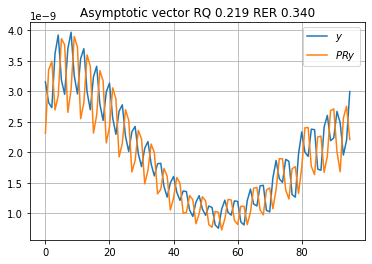

In [9]:
# Asymptotic vector of 2-level relaxation cycle at level 1 is still smooth.
p = coarse_level.p
r = coarse_level.r
plt.plot(y, label="$y$")
plt.title("Asymptotic vector RQ {:.3f} RER {:.3f}".format(level.rq(y), norm(level.operator(y))/norm(y)))
correction = p.dot(r.dot(y))
plt.plot(correction, label="$P R y$")
plt.legend()
plt.grid(True);
print(norm(y - correction) / norm(y))

In [10]:
level, coarse_level = multilevel.level[0], multilevel.level[1]
lam0 = np.real(eig(level.a.todense(), level.b.todense())[0])
lam1 = np.real(eig(coarse_level.a.todense(), coarse_level.b.todense())[0])
print(lam0)
print(lam1)

[-5.08 -5.08 -5.05 -5.02 -4.28 -5.08 -5.05 -5.02 -4.97 -4.97 -4.91 -4.91 -4.83 -4.74 -4.83 -4.74 -4.64 -4.64 -4.53 -4.53 -4.41 -4.41 -4.28 -4.14 -4.14 -3.5  -3.99 -3.99 -3.83 -3.83 -3.67 -3.67 -3.5  -3.33 -3.33 -2.97 -3.15 -3.15 -2.97 -2.26 -2.8  -2.8  -2.62 -2.62 -2.44 -2.44 -2.26 -1.74 -2.08 -2.08 -1.91 -1.91 -1.74 -1.26 -1.58 -1.58 -1.42 -1.42 -1.26 -0.83 -1.11 -1.11 -0.97 -0.97 -0.83 -0.47 -0.7  -0.7  -0.58 -0.58 -0.47 -0.36 -0.36  0.25 -0.27 -0.27 -0.18 -0.18 -0.02  0.1  -0.1  -0.1  -0.02
  0.04  0.04  0.1   0.25  0.25  0.23  0.23  0.18  0.18  0.21  0.21  0.14  0.14]
[-2.61 -2.59 -2.51 -2.37 -2.59 -2.   -2.51 -2.37 -2.2  -2.2  -2.   -0.58 -1.77 -1.77 -1.53 -1.53 -1.29 -1.29 -0.37 -1.06 -1.06 -0.67 -0.85 -0.85 -0.67 -0.3  -0.3  -0.1  -0.19 -0.19 -0.1   0.2  -0.02 -0.02  0.09  0.04  0.04  0.09  0.19  0.12  0.12  0.19  0.17  0.17  0.15  0.15  0.18  0.18]


## Level 1->2 Coarsening
Assuming level 1 was constructed with aggregate size = 4.

In [11]:
result1 = collections.OrderedDict()
for kh in kh_values:
    a = result[kh]["coarse_level"].a
    x, lam = ideal_tv(a, num_examples)
    level = hm.setup.hierarchy.create_finest_level(a)
    mock_conv = mock_cycle_conv_factor(level, x, aggregate_size_values, nu_values)
    nc = np.array([create_coarsening(a, x, num_windows, aggregate_size)[0].asarray().shape[0] 
                   for aggregate_size in aggregate_size_values])
    aggregate_size = 4
    r, s = create_coarsening(a, x, num_windows, aggregate_size)
    r_csr = r.tile(level.a.shape[0] // aggregate_size)
    p_csr = r_csr.transpose()
    coarse_level = hm.setup.hierarchy.create_coarse_level(level.a, level.b, r_csr, p_csr)
    result1[kh] = {"x": x, "lam": lam, "level": level, "mock_conv": mock_conv, "nc": nc, 
                  "aggregate_size": aggregate_size, "r": r, "s": s,
                 "coarse_level": coarse_level}

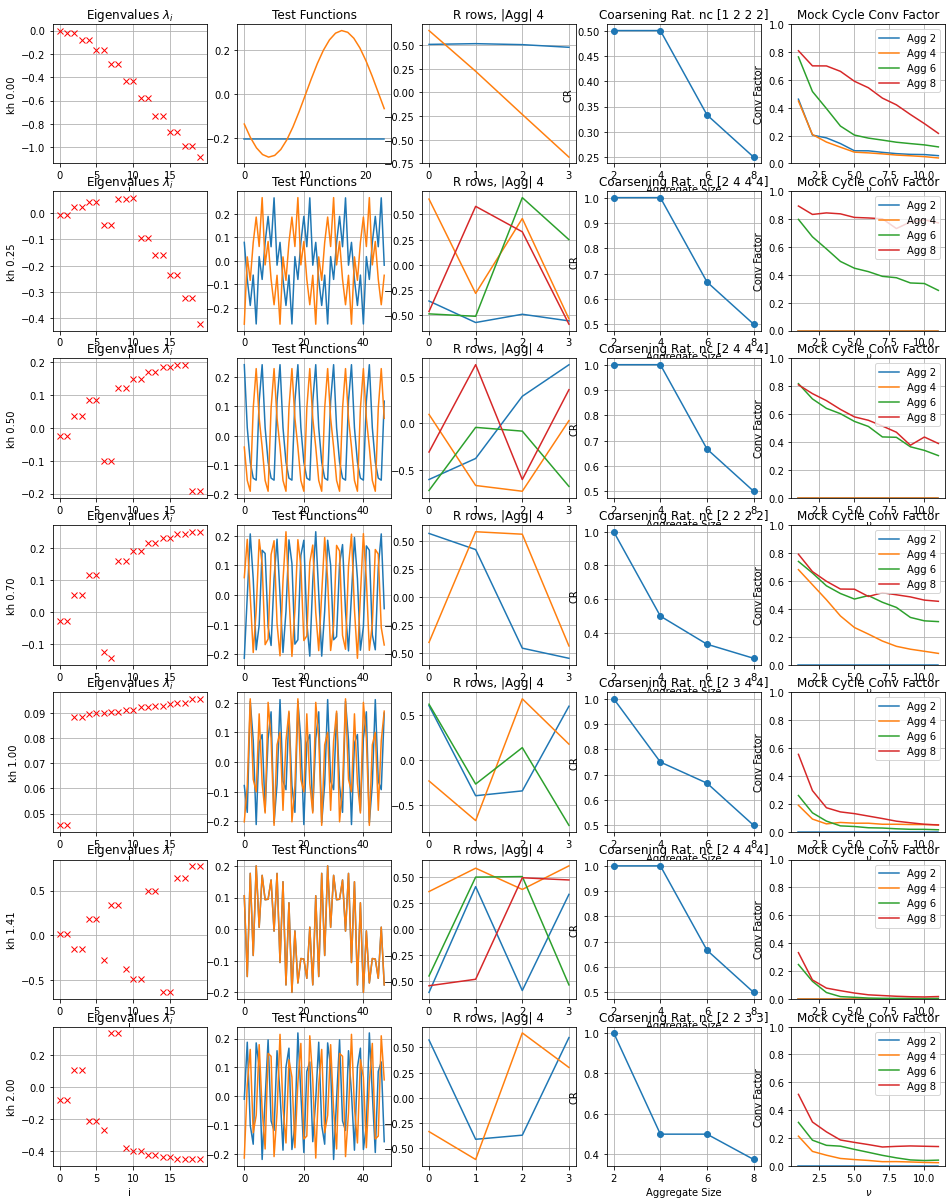

In [12]:
plot_coarsening_result(result1)

In [13]:
result1[0.5]['mock_conv']

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.82, 0.71, 0.64, 0.6 , 0.55, 0.51, 0.44, 0.43, 0.36, 0.34, 0.3 ],
       [0.81, 0.75, 0.7 , 0.63, 0.58, 0.56, 0.51, 0.47, 0.38, 0.43, 0.39]])

## Again, $kh = 0.5$ sees the worst Kaczmarz smoothing. We may be able to improve it with block Gauss-Seidel (see below).

## Effect of Level 0 Aggregate Size on Level 1 Singular Values

In [14]:
kh = 0.5
a = hm.linalg.helmholtz_1d_5_point_operator(kh, n).tocsr()
x, lam = ideal_tv(a, num_examples)
level = hm.setup.hierarchy.create_finest_level(a)
agg_sizes = np.array([2, 4, 8]) # At level 1

for aggregate_size in (4, 6, 8):
    print("Level 0 agg size", aggregate_size)
    r, s = create_coarsening(a, x, num_windows, aggregate_size)
    r_csr = r.tile(level.a.shape[0] // aggregate_size)
    p_csr = r_csr.transpose()
    coarse_level = hm.setup.hierarchy.create_coarse_level(level.a, level.b, r_csr, p_csr)

    ac = coarse_level.a
    xc, lam = ideal_tv(ac, num_examples)
    coarse_level = hm.setup.hierarchy.create_finest_level(ac)
    mock_conv = mock_cycle_conv_factor(level, x, agg_sizes, nu_values)
    nc = np.array([create_coarsening(a, x, num_windows, aggregate_size)[0].asarray().shape[0] 
                   for aggregate_size in aggregate_size_values])
    print("Mock cycle convergence Factors")
    print(mock_conv)
    print("Aggregate Sizes", agg_sizes)
    print("nc", nc)

    r, s = create_coarsening(ac, xc, num_windows, 4)
    print(r.asarray(), s)

Level 0 agg size 4
Mock cycle convergence Factors
[[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.57 0.33 0.19 0.13 0.14 0.12 0.08 0.06 0.06 0.05 0.04]
 [0.84 0.87 0.9  0.84 0.86 0.81 0.82 0.8  0.81 0.74 0.76]]
Aggregate Sizes [2 4 8]
nc [2 2 2 2]
[[-0.61 -0.38  0.29  0.63]
 [ 0.1  -0.67 -0.73  0.03]
 [-0.73 -0.04 -0.08 -0.68]
 [-0.31  0.63 -0.61  0.36]] [0.98 0.76 0.28 0.23]
Level 0 agg size 6
Mock cycle convergence Factors
[[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.59 0.32 0.19 0.13 0.14 0.12 0.09 0.06 0.06 0.05 0.05]
 [0.84 0.89 0.87 0.89 0.86 0.83 0.85 0.81 0.82 0.81 0.7 ]]
Aggregate Sizes [2 4 8]
nc [2 2 2 2]
[[ 0.56  0.44 -0.41 -0.57]
 [-0.4   0.59  0.6  -0.37]] [1.26 1.03 0.08 0.06]
Level 0 agg size 8
Mock cycle convergence Factors
[[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.59 0.33 0.19 0.13 0.14 0.12 0.08 0.06 0.06 0.05 0.05]
 [0.86 0.88 0.84 0.84 0.86 0.84 0.82 0.81 0.78 0.72 0.76]]
Aggregate Sizes [2 4 8]
nc [2 2 2 2]
[[ 0.6

Note: we observe Karsten's observation that for aggregate size of 4, there are no clear 2 SVD components at level 1 For size 6, there are just 2 components.

Mock cycle rates are good for any aggregate size at level 0, assuming aggregate size 6 at level 1.

## Comparing Kaczmarz and Block GS Smoothing for Level 1, $kh = 0.5$
Level 1 Formed by Aggregate Size = 4 at Level 0

In [15]:
kh = 0
a0 = hm.linalg.helmholtz_1d_5_point_operator(kh, n).tocsr()

In [16]:
a = result[kh]["coarse_level"].a
x, lam = ideal_tv(a, num_examples)
coarse_level = hm.setup.hierarchy.create_finest_level(a)
aggregate_size = 6
r, s = create_coarsening(a, x, num_windows, aggregate_size)
print(r.asarray(), s)

[[ 0.41  0.43  0.43  0.42  0.4   0.36]
 [ 0.56  0.35  0.12 -0.14 -0.39 -0.62]] [2.14 0.66 0.1  0.   0.   0.  ]


### Block GS

In [17]:
m = hm.solve.relax.block_tril(a, 2)

In [18]:
m.todense()[:10,:10]

matrix([[-0.58,  0.29,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
        [ 0.29, -0.58,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.29, -0.58,  0.29,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.29, -0.58,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ,  0.29, -0.58,  0.29,  0.  ,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ,  0.  ,  0.29, -0.58,  0.  ,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.29, -0.58,  0.29,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.29, -0.58,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.29, -0.58,  0.29],
        [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.29, -0.58]])

In [19]:
a.todense()[:10,:10]

matrix([[-0.58,  0.29,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
        [ 0.29, -0.58,  0.29,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.29, -0.58,  0.29,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.29, -0.58,  0.29,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ,  0.29, -0.58,  0.29,  0.  ,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ,  0.  ,  0.29, -0.58,  0.29,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.29, -0.58,  0.29,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.29, -0.58,  0.29,  0.  ],
        [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.29, -0.58,  0.29],
        [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.29, -0.58]])

In [20]:
mock_conv = mock_cycle_conv_factor(coarse_level, x, aggregate_size_values, nu_values)
print(mock_conv)

[[0.44 0.19 0.18 0.14 0.1  0.09 0.08 0.07 0.06 0.06 0.06]
 [0.43 0.22 0.15 0.12 0.08 0.07 0.06 0.06 0.05 0.05 0.04]
 [0.73 0.57 0.4  0.27 0.22 0.18 0.16 0.15 0.14 0.13 0.13]
 [0.81 0.83 0.69 0.66 0.55 0.54 0.44 0.41 0.24 0.28 0.18]]


In [21]:
level_bgs = hm.setup.hierarchy.create_finest_level(a, relaxer=hm.solve.relax.GsRelaxer(a, block_size=2, omega=1))
mock_conv_bgs = mock_cycle_conv_factor(level_bgs, x, aggregate_size_values, nu_values)
print(mock_conv_bgs)

[[0.25 0.1  0.08 0.07 0.06 0.05 0.05 0.04 0.04 0.03 0.03]
 [0.2  0.03 0.02 0.01 0.01 0.   0.   0.   0.   0.   0.  ]
 [0.28 0.07 0.03 0.03 0.02 0.01 0.01 0.01 0.   0.   0.  ]
 [0.4  0.12 0.06 0.04 0.03 0.02 0.02 0.01 0.01 0.01 0.01]]


Looks like Block GS diverges. Let's check first for Poisson.

### Sanity Check: Block GS Mock Cycle Convergence for Poisson
For aggregate sizes 2, 4, 6, vs. $\nu=1,\dots,5$.

In [22]:
a = hm.linalg.helmholtz_1d_5_point_operator(0.0, n).tocsr()
x, lam = ideal_tv(a, num_examples)

print("relax")
level = hm.setup.hierarchy.create_finest_level(a)
print(mock_cycle_conv_factor(level, x, [2, 4, 6], nu_values))

print("GS")
level_bgs = hm.setup.hierarchy.create_finest_level(a, relaxer=hm.solve.relax.GsRelaxer(a, block_size=1))
mock_conv_bgs = mock_cycle_conv_factor(level_bgs, x, [2, 4, 6], nu_values)
print(mock_conv_bgs)

print("GS, block size 2")
level_bgs = hm.setup.hierarchy.create_finest_level(a, relaxer=hm.solve.relax.GsRelaxer(a, block_size=2))
mock_conv_bgs = mock_cycle_conv_factor(level_bgs, x, [2, 4, 6], nu_values)
print(mock_conv_bgs)

Kaczmarz
[[0.51 0.23 0.21 0.2  0.15 0.1  0.1  0.1  0.08 0.08 0.08]
 [0.83 0.84 0.81 0.75 0.7  0.63 0.63 0.55 0.51 0.5  0.44]
 [0.84 0.86 0.85 0.89 0.9  0.84 0.87 0.86 0.83 0.83 0.81]]
GS
[[0.34 0.14 0.1  0.03 0.03 0.02 0.02 0.01 0.01 0.01 0.01]
 [0.62 0.42 0.2  0.12 0.09 0.08 0.08 0.07 0.06 0.06 0.05]
 [0.72 0.65 0.52 0.42 0.33 0.26 0.2  0.15 0.12 0.11 0.11]]
GS, block size 2
[[0.29 0.15 0.11 0.1  0.08 0.07 0.07 0.06 0.06 0.06 0.05]
 [0.51 0.23 0.13 0.1  0.09 0.08 0.07 0.07 0.06 0.06 0.05]
 [0.64 0.46 0.29 0.22 0.15 0.12 0.11 0.1  0.07 0.08 0.07]]


OK, at least in this case we have BGS reasonable convergence (for aggregate size = 2).

## Relaxation Shrinkage Factor
Shrinkage Factor ~ generalized smoothing factor: the reduction in RER after 10 sweeps, starting from random error.

### Level 0

In [49]:
a = multilevel.level[0].a
print(a.shape)
operator = lambda x: a.dot(x)

# Kaczmarz.
relaxer = hm.solve.relax.KaczmarzRelaxer(a)
f = hm.solve.smoothing.shrinkage_factor(operator, relaxer, (a.shape[0],))
print("Kaczmarz Shrinkage factor {:.3f}".format(f))

# # GS.
# relaxer = hm.solve.relax.GsRelaxer(a, block_size=1)
# f = hm.solve.smoothing.shrinkage_factor(operator, relaxer, (a.shape[0],))
# print("GS       Shrinkage factor {:.3f}".format(f))

(96, 96)
INFO         0 |r| 1.29711296e+00 RER 2.91310
INFO         0 |r| 7.25221314e-01 RER 2.12747
INFO         0 |r| 4.24111813e-01 RER 1.45277
INFO         0 |r| 2.63471420e-01 RER 0.98290
INFO         0 |r| 1.80024613e-01 RER 0.70612
INFO         0 |r| 1.33885237e-01 RER 0.54326
Kaczmarz Shrinkage factor 0.717


### Level 1

In [50]:
a = multilevel.level[1].a
#a = coarse_level.a
print(a.shape)
operator = lambda x: a.dot(x)

# # GS.
# relaxer = hm.solve.relax.GsRelaxer(a, block_size=1)
# f = hm.solve.smoothing.shrinkage_factor(operator, relaxer, (a.shape[0],))
# print("GS       Shrinkage factor {:.3f}".format(f))


# # GS, block size = 2.
# relaxer = hm.solve.relax.GsRelaxer(a, block_size=2)
# f = hm.solve.smoothing.shrinkage_factor(operator, relaxer, (a.shape[0],))
# print("GS-B2    Shrinkage factor {:.3f}".format(f))

# Block Kaczmarz with varying block sizes.
for block_size in range(1, 5):
    relaxer = hm.solve.relax.KaczmarzRelaxer(a, block_size=block_size)
    f = hm.solve.smoothing.shrinkage_factor(operator, relaxer, (a.shape[0],), num_sweeps=5)
    print("Kaczmarz block size {}, Shrinkage factor {:.3f}".format(block_size, f))

(48, 48)
INFO         0 |r| 5.66663867e-01 RER 1.27292
INFO         0 |r| 1.39764070e-01 RER 0.45913
INFO         0 |r| 1.02403924e-01 RER 0.36454
INFO         0 |r| 8.85172778e-02 RER 0.33332
INFO         0 |r| 7.90302278e-02 RER 0.31274
INFO         0 |r| 7.14582349e-02 RER 0.29596
Kaczmarz block size 1, Shrinkage factor 0.749
INFO         0 |r| 5.60255697e-01 RER 1.25289
INFO         0 |r| 1.50355283e-01 RER 0.49465
INFO         0 |r| 1.07670557e-01 RER 0.38351
INFO         0 |r| 9.25583906e-02 RER 0.35086
INFO         0 |r| 8.09448714e-02 RER 0.32492
INFO         0 |r| 7.15899038e-02 RER 0.30252
Kaczmarz block size 2, Shrinkage factor 0.755
INFO         0 |r| 5.57788063e-01 RER 1.24844
INFO         0 |r| 1.14958759e-01 RER 0.39794
INFO         0 |r| 8.33380706e-02 RER 0.32160
INFO         0 |r| 6.95614404e-02 RER 0.29166
INFO         0 |r| 5.93226190e-02 RER 0.26510
INFO         0 |r| 5.15855845e-02 RER 0.24233
Kaczmarz block size 3, Shrinkage factor 0.724
INFO         0 |r| 6.2017

In [44]:
# # Block GS with under-relaxation.
# print_shrinkage_factor(coarse_level.a, relaxer=hm.solve.relax.GsRelaxer(coarse_level.a, block_size=2, omega=0.1))

Even a strong under-relaxation GS diverges.

## Strength of Connection (Cosine Similarity)

In [26]:
def print_cosine_similarities(a, aggregate_size: int = 10):
    # Using relaxed vectors.
    x = hm.solve.run.random_test_matrix((a.shape[0],), num_examples=num_examples)
    b = np.zeros_like(x)
    level = hm.setup.hierarchy.create_finest_level(a)
    x, relax_conv_factor = hm.solve.run.run_iterative_method(
        level.operator, lambda x: level.relax(x, b), x,num_sweeps=10)
    x_relaxed = x

    # Using idealized vectors. Importantly, use more than just the two AZMs, for diversity.
    # Using 10 vectors x 10 windows from each.
    aggregate_size = 10
    x_ideal = ideal_tv(a, 10)[0]

    for title, x in (("Ideal", x_ideal), ("Relaxed", x_relaxed)):
        print("{} vectors".format(title))
        y = np.concatenate(tuple(hm.linalg.get_window(x, offset, aggregate_size) 
                             for offset in range(num_windows)), axis=1).transpose()
        y /= norm(y, axis=0)
        cos_distance = np.abs(y.transpose().dot(y))

        print(cos_distance)
        # fig, ax = plt.subplots(figsize=(8, 8))
        # im = ax.imshow(cos_distance, plt.get_cmap("seismic"))

        # # Loop over data dimensions and create text annotations.
        # for i in range(cos_distance.shape[0]):
        #     for j in range(cos_distance.shape[1]):
        #         text = ax.text(j, i, "{:.2f}".format(cos_distance[i, j]),
        #                        ha="center", va="center", color="w")

        # ax.set_title("Level 1 Cosine Similarity")
        # fig.tight_layout()
        # plt.show()

#### Level 0
The correlations decrease like a $cos(kd)$, where $d$ is the distance between points, as Achi calculated. This is seen more clearly in ideal vectors, although relaxed vectos exhibit some of this behavior, espeically for the strongest correlations.

In [27]:
print_cosine_similarities(a0)

Ideal vectors
[[1.   0.98 0.93 0.85 0.75 0.62 0.48 0.34 0.2  0.08]
 [0.98 1.   0.98 0.93 0.85 0.74 0.62 0.48 0.33 0.2 ]
 [0.93 0.98 1.   0.98 0.93 0.85 0.74 0.61 0.47 0.33]
 [0.85 0.93 0.98 1.   0.98 0.93 0.85 0.74 0.61 0.47]
 [0.75 0.85 0.93 0.98 1.   0.98 0.93 0.84 0.73 0.6 ]
 [0.62 0.74 0.85 0.93 0.98 1.   0.98 0.93 0.84 0.73]
 [0.48 0.62 0.74 0.85 0.93 0.98 1.   0.98 0.93 0.84]
 [0.34 0.48 0.61 0.74 0.84 0.93 0.98 1.   0.98 0.93]
 [0.2  0.33 0.47 0.61 0.73 0.84 0.93 0.98 1.   0.98]
 [0.08 0.2  0.33 0.47 0.6  0.73 0.84 0.93 0.98 1.  ]]
Relaxed vectors
[[1.   0.89 0.6  0.24 0.05 0.23 0.32 0.3  0.17 0.08]
 [0.89 1.   0.88 0.57 0.22 0.08 0.28 0.36 0.31 0.13]
 [0.6  0.88 1.   0.88 0.57 0.22 0.07 0.27 0.35 0.27]
 [0.24 0.57 0.88 1.   0.88 0.6  0.27 0.04 0.23 0.3 ]
 [0.05 0.22 0.57 0.88 1.   0.89 0.63 0.29 0.01 0.19]
 [0.23 0.08 0.22 0.6  0.89 1.   0.9  0.62 0.29 0.02]
 [0.32 0.28 0.07 0.27 0.63 0.9  1.   0.89 0.62 0.31]
 [0.3  0.36 0.27 0.04 0.29 0.62 0.89 1.   0.9  0.64]
 [0.17 0.31 0.3

#### Level 1

In [28]:
print_cosine_similarities(coarse_level.a)

Ideal vectors
[[1.   0.74 0.18 0.18 0.15 0.04 0.11 0.02 0.05 0.03]
 [0.74 1.   0.73 0.19 0.16 0.14 0.03 0.1  0.02 0.04]
 [0.18 0.73 1.   0.74 0.19 0.17 0.15 0.04 0.11 0.03]
 [0.18 0.19 0.74 1.   0.73 0.18 0.17 0.14 0.04 0.1 ]
 [0.15 0.16 0.19 0.73 1.   0.73 0.2  0.16 0.15 0.03]
 [0.04 0.14 0.17 0.18 0.73 1.   0.74 0.18 0.18 0.15]
 [0.11 0.03 0.15 0.17 0.2  0.74 1.   0.73 0.18 0.17]
 [0.02 0.1  0.04 0.14 0.16 0.18 0.73 1.   0.74 0.19]
 [0.05 0.02 0.11 0.04 0.15 0.18 0.18 0.74 1.   0.73]
 [0.03 0.04 0.03 0.1  0.03 0.15 0.17 0.19 0.73 1.  ]]
Relaxed vectors
[[1.   0.85 0.48 0.1  0.13 0.12 0.03 0.23 0.41 0.51]
 [0.85 1.   0.85 0.48 0.05 0.2  0.22 0.08 0.15 0.37]
 [0.48 0.85 1.   0.84 0.41 0.03 0.26 0.29 0.15 0.1 ]
 [0.1  0.48 0.84 1.   0.81 0.38 0.   0.23 0.29 0.18]
 [0.13 0.05 0.41 0.81 1.   0.83 0.49 0.14 0.13 0.25]
 [0.12 0.2  0.03 0.38 0.83 1.   0.88 0.6  0.25 0.06]
 [0.03 0.22 0.26 0.   0.49 0.88 1.   0.9  0.62 0.27]
 [0.23 0.08 0.29 0.23 0.14 0.6  0.9  1.   0.9  0.62]
 [0.41 0.15 0.1

Here it is not clear if there are any strong correlations. So how come relaxation converges so slowly? Shouldn't Gauss-Seidel be fast in this case?